# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [150]:
import seaborn as sb #для графика с линией линейной регрессией
import numpy as np 
import matplotlib.pyplot as plt #для функции show
import matplotlib.dates as mdates
from scipy import stats #чтобы подсчитать p-value корреляций Пирсона

## Откройте файл с данными и изучите общую информацию. 

In [15]:
import pandas as pd

try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

In [16]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [18]:
#Смотрим, есть ли тут дубликаты
data.duplicated().sum()
# Дубликатов нет!

0

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

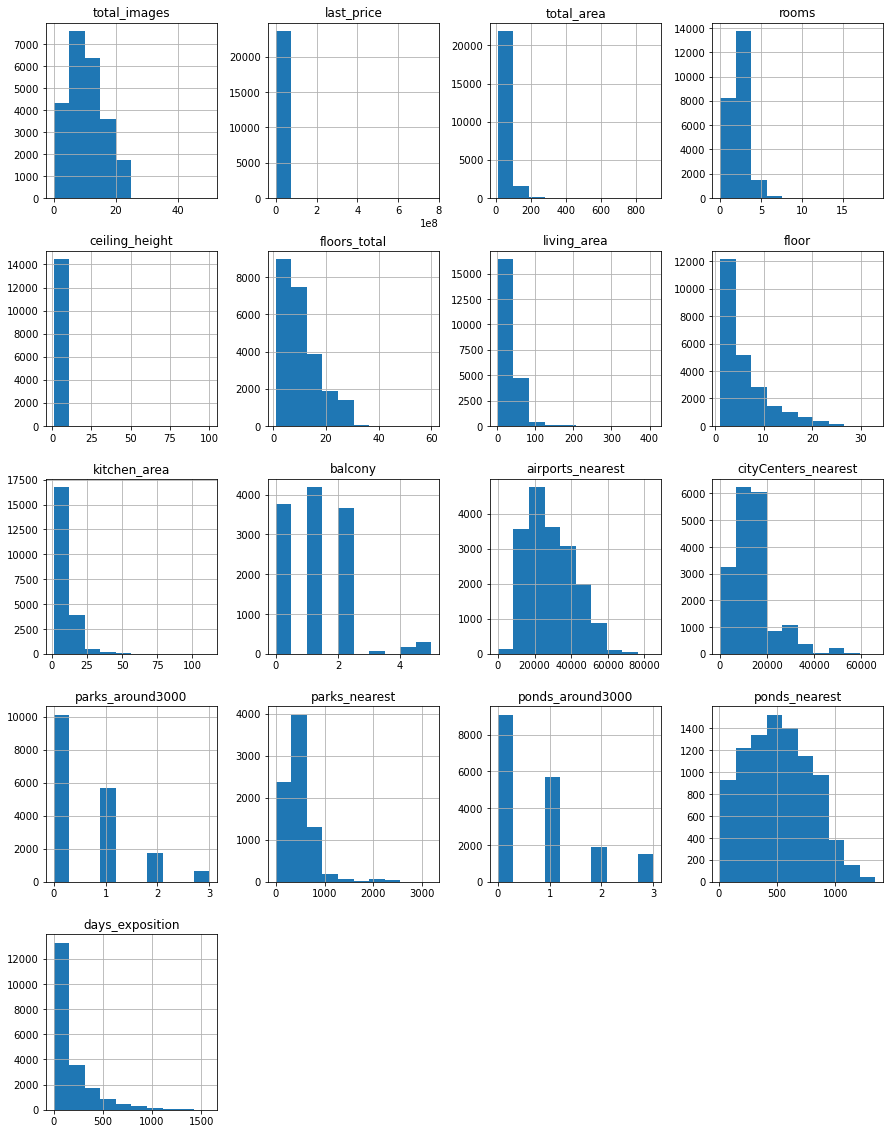

In [19]:
data.hist(figsize=(15, 20))

1) Пропусков много, возможно, они скашивают часть распределений

2) В last_price значения слишком большие, можно попробовать логарифмировать значения в этой колонке, чтобы что-то увидеть)

3) Парки и пруды в радиусе 3000 принимают значения от 0 до 3

4) В total_area, living_area похоже не хватает bins, чтобы что-то увидеть

## Предобработка данных

### ***Найдите и изучите пропущенные значения в столбцах:***


In [20]:
data.isna().sum() #посмотрим, сколько у нас пропусков и где они

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски есть в столбцах:

+ ceiling_height - 9195
+ floors_total - 86
+ living_area - 1903
+ is_apartment - 20964
+ kitchen_area - 2278
+ balcony - 11519
+ airports_nearest - 5542
+ cityCenters_nearest - 5519
+ parks_around3000 - 5518
+ parks_nearest - 15620
+ ponds_around3000 - 5518
+ ponds_nearest - 14589
+ days_exposition - 3181
+ locality_name - 49

In [21]:
((86+49)/23699)*100

0.5696442887885564

В столбцах locality_name и floors_total суммарно всего 135 пропусков, что составляет 0.5% от всех данных. Так как время на выполнение проекта ограничено, оставим эти пропуски как есть.

Далее смотрим на столбец balcony. Логика в примере из задания кажется рабочей, поэтому предположим, что пропуски в этом столбце означают, что балкона в квартире нет.

In [22]:
data.loc[data['balcony'].isna(), 'balcony'] = 0 #заменяем пропуски на 0
data['balcony'].isna().sum() #проверяем, что пропусков не осталось

0

***
Дальше посмотрим на столбец с самым большим числом пропусков - is_apartment. Столбец указывает, является ли помещение апартаментами.

In [23]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

is_apartment
False    2725
True       50
Name: is_apartment, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,count,mean,median
,price_per_m,price_per_m,price_per_m
is_apartment,,,
False,2725,98527.587107,93333.333333
True,50,148353.726856,113866.503298


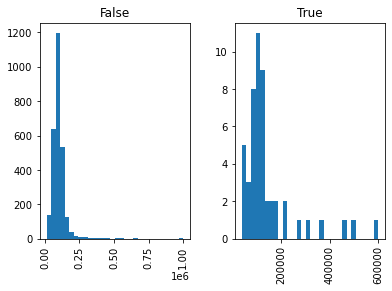

In [24]:
#посмотрим, в каких объявлениях указаны значения True и False
is_app =data[~data['is_apartment'].isna()]
is_app.loc[:, 'price_per_m'] = is_app['last_price']/is_app['total_area'] #подсчитаем цену за м2
is_app.hist(column = 'price_per_m', by = 'is_apartment', bins = 30) #посмотрим на распределение цен
print(is_app.groupby('is_apartment')['is_apartment'].count())#подсчитаем, сколько вообще апартаментов
is_app.query('is_apartment == True').head(50)#посмотрим на все апартаменты, попробуем прикинуть отличия на глаз
is_app.pivot_table(index = 'is_apartment', values = 'price_per_m',
                   aggfunc = ['count', 'mean', 'median'])

**Итог по пропускам в статусе помещения апартаменты/не апартаменты:**
Похоже, иногда пользователи просто не указывают его. Возможно, это связано с тем, что с владением апартаментами связано гораздо больше сложностей, поэтому так продавцы надеются привлечь больше потенциальных покупателей. 

Так как это важная характеристика помещения для покупателя, было бы полезно заполнить пропуски. Единственная характеристика, по которой можно было бы достоверно отличить апартаменты от жилых помещений - снижение цены за метр квадратный на 15-20% (согласно текущей статистике). К сожалению, в данной выборке представлено только 50 квартир с установленным статусом "апартаменты", поэтому подсчет средней и медианной цены показывает, что цена на апартаменты, наоборот, выше, чем на жилые квартиры. Так как в дальнейшим для анализа этот показатель использоваться не будет, оставим пока эту колонку в изначальном виде.

***
Дальше посмотрим на колонки park_nearest и pond_nearest, где также большая доля пропусков. Эти колонки связаны с ponds_around3000 и parks_around3000, при этом в последних пропусков в три раза меньше.

Гипотеза: пропуски и 0 в ponds_around3000 и parks_around3000 совпадают с пропусками в park_nearest и pond_nearest 

In [25]:
no_ponds = data[(data['ponds_around3000'].isna()) | (data['ponds_around3000'] == 0)]
print(len(no_ponds['last_price']) == no_ponds['ponds_nearest'].isna().sum())

True


В случае с прудами гипотеза подтвердилась - если в ponds_around3000 пропуск или 0, в pond_nearest пропуск. 
Кажется правдоподобно, что если в колонке ponds_around3000 пропуск, пруда рядом нет. 

Заменим пропуски в ponds_around3000 на 0. Пропуски в pond_nearest оставим как есть - они показывают, что пруда рядом нет. Если заменить их на 0 или другое число, это может сбить дальнейший анализ связи цены и близости пруда для тех квартир, у которых рядом есть водоем.

In [26]:
no_parks = data[(data['parks_around3000'].isna()) | (data['parks_around3000'] == 0)]
print(len(no_parks['last_price']) == no_parks['parks_nearest'].isna().sum())
print(len(no_parks['last_price']))
print(no_parks['parks_nearest'].isna().sum())
no_parks[~no_parks['parks_nearest'].isna()]

False
15624
15620


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1590,3,7500000.0,70.0,2017-07-11T00:00:00,2,NaN,18.0,37.0,13,NaN,...,10.0,0.0,Санкт-Петербург,14878.0,9791.0,0.0,3064.0,1.0,264.0,4.0
10959,9,3000000.0,31.1,2017-03-21T00:00:00,1,NaN,5.0,17.7,2,NaN,...,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,234.0
19208,17,14950000.0,187.0,2017-10-12T00:00:00,5,3.0,2.0,80.0,2,NaN,...,17.0,1.0,Санкт-Петербург,36805.0,8656.0,0.0,3013.0,3.0,537.0,49.0
19430,9,3900000.0,30.5,2018-02-22T00:00:00,1,2.6,5.0,16.5,1,NaN,...,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,176.0


В случае с парками нашлись четыре квартиры, где нет парков в радиусе 3км, но есть ну-почти в радиусе 3км, для них указаны эти ну-почти значения. Во всех остальных случаях, у таких квартир в park_nearest пропуски. Как и в случае с прудами, заменим пропуски в parks_around3000 на 0, а пропуски в park_nearest оставим без изменений с учетом будущего анализа.

In [27]:
data.loc[data['ponds_around3000'].isna(), 'ponds_around3000'] = 0 #заменяем пропуски в прудах на 0
data.loc[data['parks_around3000'].isna(), 'parks_around3000'] = 0 #заменяем пропуски в парках на 0
print(data['ponds_around3000'].isna().sum())
data['parks_around3000'].isna().sum()

0


0

In [28]:
data['ponds_nearest'].max() 
data['parks_nearest'].max()
print(data['ponds_nearest'].min())
data['parks_nearest'].min()
#проверяем, есть ли парки и пруды дальше 3км в полных данных

13.0


1.0

**Итог по пропускам в столбцах ponds_around3000, ponds_nearest, parks_around3000 и parks_nearest:**
Мы предположили, что пропуски в ponds_around3000 и parks_around3000 означают, что парков и прудов в радиусе 3км нет. На это также косвенно указывает и то, что в данных только 4 квартиры, у которых указано расстояние parks_nearest больше 3км (и они очень близко к 3км), а для водоемов таких квартир нет вообще. Мы заменили пропуски в ponds_around3000 и parks_around3000 на 0.

Пропуски в parks_nearest и ponds_nearest пока оставлены без изменений, так как замена на медианное/среднее значение здесь искажает данные, как и замена на 0. В дальнейшем анализе эти квартиры попадут к категорию "парка рядом нет" или "водоема рядом нет", а замена пропусков на строковые значения может осложнить анализ численных значений в столбце.

***
Дальше попробуем разобраться с пропусками в столбцах airports_nearest и cityCenters_nearest.

Гипотеза: эти значения пропущены для мест типа поселок, село и т.п.

(Всего пропусков в столцах:
airports_nearest      -   5542,
cityCenters_nearest   -   5519)

In [29]:
#для удобства выделим эти строки в отдельный датафрейм
air_city = data[(data['airports_nearest'].isna()) | (data['cityCenters_nearest'].isna())] 
#print(air_city.count())
#заодно подсчитаем, какую часть данных составляют строки с пропусками
print(len(air_city['last_price'])/len(data['last_price'])) 
print(len(air_city['locality_name'].unique()))
air_city['locality_name'].unique()
#посмотрим на названия мест. В основном поселки, но также затесался Санкт-Петербург
air_city[air_city['locality_name'] == 'Санкт-Петербург']
#В Санкт-Петербурге есть 85 квартир с пропусками в расстоянии до центра или аэропорта.

0.23389172538925693
346


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
81,9,10949000.0,68.00,2018-12-27T00:00:00,1,NaN,10.0,NaN,6,NaN,...,NaN,0.0,Санкт-Петербург,NaN,NaN,0.0,NaN,0.0,NaN,NaN
593,20,4200000.0,38.30,2019-04-16T00:00:00,1,2.60,16.0,19.8,10,NaN,...,10.1,2.0,Санкт-Петербург,NaN,NaN,0.0,NaN,0.0,NaN,NaN
604,11,9899000.0,101.00,2018-12-12T00:00:00,3,3.00,5.0,62.0,3,NaN,...,15.0,0.0,Санкт-Петербург,NaN,NaN,0.0,NaN,0.0,NaN,NaN
733,18,18700000.0,109.70,2018-02-03T00:00:00,3,2.75,21.0,57.2,13,NaN,...,15.3,1.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,NaN,112.0
742,7,37000000.0,161.00,2016-05-22T00:00:00,3,NaN,9.0,84.0,8,NaN,...,NaN,0.0,Санкт-Петербург,NaN,NaN,0.0,NaN,0.0,NaN,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21955,19,130000000.0,431.00,2017-10-02T00:00:00,7,3.70,8.0,220.0,5,NaN,...,20.0,5.0,Санкт-Петербург,NaN,NaN,0.0,NaN,0.0,NaN,161.0
22554,5,3415000.0,31.65,2019-04-16T00:00:00,1,NaN,24.0,NaN,14,NaN,...,8.7,2.0,Санкт-Петербург,NaN,NaN,0.0,NaN,0.0,NaN,NaN
22628,8,8600000.0,74.90,2019-03-14T00:00:00,3,3.00,5.0,53.2,4,NaN,...,8.0,1.0,Санкт-Петербург,NaN,NaN,0.0,NaN,0.0,NaN,NaN
22790,8,5600000.0,47.00,2017-09-27T00:00:00,1,NaN,23.0,21.0,7,NaN,...,11.0,1.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,NaN,10.0


Гипотеза подвердилась, расстояние до центра города и/или аэропорта в основном отсуствует для квартир в местах типа:

    - городской посёлок
    - поселок
    - деревня
    - коттеджный поселок
    - садовое товарищество
    - поселок городского типа
    - село

Квартиры с пропусками в этих столбцах составляют 23% всех данных, то есть достаточно существенную часть. Также вполне возможно, что часть этих пунктов находятся на самом деле ближе к аэропорту, чем квартиры в Санкт-Петербурге. То же самое можно сказать и о центре города, если поселок находится рядом с городом, то он может быть ближе к центру, чем некоторые квартиры в отдаленных районах. 

Попробуем заполнить пропуски средними значениями по населенному пункту. 

In [30]:
for i in data['locality_name'].unique():
    data.loc[(data['locality_name'] == i) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['locality_name'] == i), 'airports_nearest'].mean()

In [31]:
data['airports_nearest'].isna().sum()
#Число пропусков уменьшилось с 5524 до 5394, 
#похоже, у большинства квартир в этих пунктах пропущено расстояние до аэропорта во всех объявлениях.

5394

In [32]:
for i in data['locality_name'].unique():
    data.loc[(data['locality_name'] == i) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['locality_name'] == i), 'cityCenters_nearest'].mean()

In [33]:
data['cityCenters_nearest'].isna().sum()
#Здесь число пропусков тоже уменьшилось с 5519 до 5394.

5394

In [34]:
#посмотрим, сколько населенных пунктов "нашлись"
air_city = data[(data['airports_nearest'].isna()) | (data['cityCenters_nearest'].isna())] 
print(len(air_city['locality_name'].unique()))
len(air_city['locality_name'].unique())
#346-337 = 9
#мы заполнили пропуски для 9 населенных пунктов.

337


337

**Итог по пропускам в значениях airports_nearest и cityCenters_nearest:**
Средними значениями по населенному пункту удалось заполнить пропуски только для 9 из них, у большинства из них расстояние до аэропорта и до центра города не указано ни для одной квартиры. Дальнейшим шагом можно было бы найти оставшиеся поселки на карте и заполнить расстояния внучную. Однако это довольно трудоемкий шаг, поэтому мы попробуем пока обойтись без него. Оставим пропуски без изменений и выделим эти поселки в отдельную группу при дальнейшем анализе.

***
Далее посмотрим на пропуски в столбцах living_area и kitchen_area. 

Жилая площадь должна быть связана с общей площадью. Попробуем разделить квартиры на категории по общей площади и заполнить пропуски living_area по медианным значениям этих категорий (здесь используем медиану, чтобы подстраховаться от возможных выбросов).

564

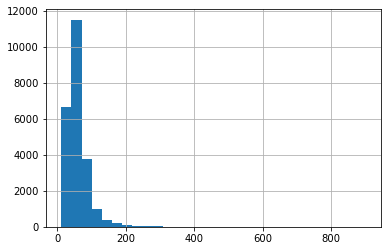

In [35]:
data['total_area'].hist(bins = 30) #посмотрим на распределение

#сделаем 10 категорий с примерно одинаковой общей площадью
len(data.query('total_area > 150'))

#квартиры с площадью больше 150 м2 составляют очень небольшую чатсь данных, 
#однако для этих квартир жилая площадь будет сильно отличаться от квартир меньшего размера. 

#Выделим их в отдельную группу

In [36]:
def categ_area(area):
    try:
        if 11.999 <= area <= 37.6:
            return '1'
        elif 37.6 <= area <= 46.030001:
            return '2'
        elif 46.0 <= area <= 58.0:
            return '3'
        elif 58.0 <= area <= 68.0:
            return '4'
        elif 68.1 <= area <= 78.0:
            return '5'
        elif 68.1 <= area <= 78.0:    
            return '6'
        elif 78.1 <= area <= 88.0:    
            return '7'
        elif 88.1 <= area <= 98.0:    
            return '8'
        elif 98.1 <= area <= 150.0:    
            return '9'
        else:
            return '10'
    except:
        pass

In [37]:
data['total_area_category'] = data['total_area'].apply(categ_area)

In [38]:
for i in data['total_area_category'].unique():
    data.loc[(data['total_area_category'] == i) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['total_area_category'] == i), 'living_area'].median()

In [39]:
data['living_area'].isna().sum()

0

Дальше заполним пропуски в kitchen_area. Можно было бы просто вычесть жилую площадь и общей площадь, однако в квартирах обычно есть также нежилая И некухонная площадь, так что результат может быть искажен.

Попробуем снова заполнить пропуски их медианами по категориям total_area.

In [40]:
for i in data['total_area_category'].unique():
    data.loc[(data['total_area_category'] == i) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['total_area_category'] == i), 'kitchen_area'].median()

In [41]:
data['kitchen_area'].isna().sum()

0

In [42]:
#посмотрим, как total_area сходится с суммой living_area и kitchen_area
data['living_kitchen'] = data['living_area'] + data['kitchen_area']
anomaly_area = data.query('(total_area - living_kitchen) < 0')
anomaly_area.loc[:, 'extra_area'] = anomaly_area['total_area'] - anomaly_area['living_kitchen']
print(anomaly_area['extra_area'].mean())
anomaly_area['extra_area'].median()
#пострадали от аномальных метров всего 269 строк 
#среди них среднее отклонение составляет -3.8 м, а медиана -2.5


-3.792713776951673


C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


-2.5

**Итог по пропускам значений в living_area и kitchen_area:**

Мы разделили квартиры на категории по общей площади (total_area) и заполнили пропуски living_area и kitchen_area по медианным значениям этих столбцов для каждой категории. Здесь мы использовали медиану, чтобы подстраховаться от эффекта выбросов на среднее. 

***
Далее посмотрим на столбец ceiling_height

0          (2.65, 2.8]
1                  NaN
2                  NaN
3                  NaN
4         (2.8, 100.0]
             ...      
23694     (2.8, 100.0]
23695              NaN
23696              NaN
23697     (2.8, 100.0]
23698    (0.999, 2.52]
Name: ceiling_height, Length: 23699, dtype: category
Categories (4, interval[float64, right]): [(0.999, 2.52] < (2.52, 2.65] < (2.65, 2.8] < (2.8, 100.0]]


<AxesSubplot:xlabel='cityCenters_nearest', ylabel='ceiling_height'>

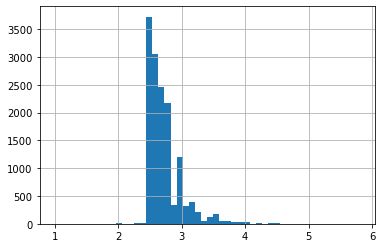

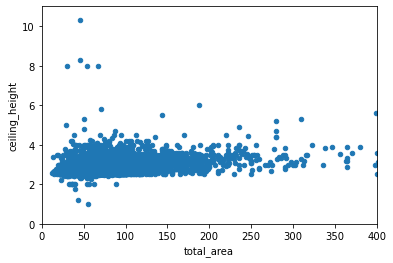

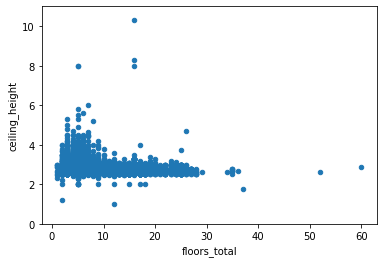

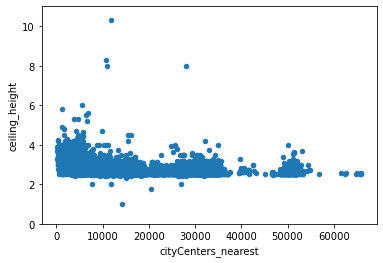

In [43]:
#data['ceiling_height'].hist(bins = 50)
data.query('ceiling_height < 6')['ceiling_height'].hist(bins = 50)
data['ceiling_height'].median()

#поделим значения на четыре равные группы
print(pd.qcut(data['ceiling_height'], 4))
#видим, что 50% значений попадают в размах 2.52-2.8м

#Возможно, с высотой потолка связаны другие параметры: 
# число этажей в доме (например, в старых малоэтажных домах потолки выше)
# общая площадь квартиры (может быть, в больших квартирах потолки выше)
# место (дальше от центра/ближе могут быть различия)

data.plot(kind = 'scatter', x = 'total_area', y = 'ceiling_height', ylim = [0,11], xlim = [0,400])
data.plot(kind = 'scatter', x = 'floors_total', y = 'ceiling_height', ylim = [0,11])
data.plot(kind = 'scatter', x = 'cityCenters_nearest', y = 'ceiling_height', ylim = [0,11])

#эх, никаких закономерностей не видно.

In [44]:
#Заменим пропуски на медианные значения
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median() #заменяем пропуски
data['ceiling_height'].isna().sum() #проверяем, что пропусков не осталось


0

***
Остался последний столбец с пропусками - days_exposition, то есть сколько дней было размещено объявление (от публикации до снятия).

Гипотеза: пропуски связаны с тем, что на момент выгрузки датасета объявление еще не было снято.

Предположим, что чаще это будут недавние объявления. Для начала выделим год объявления.

In [45]:
print(data['first_day_exposition'])
print()
#пока даты в формате строк, так что просто отрежем первые 4 символа
data['year'] = data['first_day_exposition'].str[:4]
#а теперь подсчитаем пропуски в days_exposition по годам
for year in data['year'].unique():
    print(year, 'год:', data.query('year == @year')['days_exposition'].isna().sum())

print()
print('Пропуски 2019 года составляют от всех пропусков:',1796/data['days_exposition'].isna().sum())
print('Пропуски 2018 года составляют от всех пропусков:',959/data['days_exposition'].isna().sum())

0        2019-03-07T00:00:00
1        2018-12-04T00:00:00
2        2015-08-20T00:00:00
3        2015-07-24T00:00:00
4        2018-06-19T00:00:00
                ...         
23694    2017-03-21T00:00:00
23695    2018-01-15T00:00:00
23696    2018-02-11T00:00:00
23697    2017-03-28T00:00:00
23698    2017-07-21T00:00:00
Name: first_day_exposition, Length: 23699, dtype: object

2019 год: 1796
2018 год: 959
2015 год: 70
2017 год: 271
2016 год: 67
2014 год: 18

Пропуски 2019 года составляют от всех пропусков: 0.5646023263124803
Пропуски 2018 года составляют от всех пропусков: 0.30147752279157497


Действительно, большая часть квартир (86%) с пропусками в days_exposition были размещены в 2019 и 2018 году, что соотвествует нашей гипотезе - скорее всего, пропуски показывают, что объявление о продаже квартиры все еще не было снято, когда был выгружен датасет. 

Можно было бы подсчитать примерно дату выгрузки датасета и вычесть из нее дату выставления квартиры на продажу, однако на наш вгляд лучше оставить пропуски, так как по факту выведенная цифра не будет отражать, сколько квартира на самом деле "висела" до продажи (или снятия с сайта).

### ***Работа с типами данных, уникальными значениями и редкими значениями:***

Найдем столбцы, в которых нужно изменить тип данных. Преобразуем тип данных в выбранных столбцах. В ячейке с типом markdown поясним, почему нужно изменить тип данных.


In [46]:
# Сначала посмотрим на типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

***

 
 - Столбец first_day_exposition, который является датой, сейчас имеет тип object, заменим его на datetime для удобства
 - Is apartment сейчас имеет тип object, хотя принимает значения True и False, заменим на bool
 - Столбцы parks_around3000, ponds_around3000 и balcony имеют тип float64, хотя по идее все значения в этих столбцах должны быть целыми числами - проверим, в чем дело, заменим на int.
 (Это также относится к столбцам floors_total и  days_exposition, но в них мы оставили NaN, которые не могут быть int)

In [47]:
data['first_day_exposition'] =  pd.to_datetime(data['first_day_exposition'], format='%Y%m%dT%H:%M:%S')
data['first_day_exposition'].head(2)
#Заменили тип на datetime

0   2019-03-07
1   2018-12-04
Name: first_day_exposition, dtype: datetime64[ns]

In [48]:
data.loc[data['is_apartment'] == 'True', 'is_apartment'] = True

In [49]:
data.loc[data['is_apartment'] == 'False', 'is_apartment'] = False

Если менять тип данных в столбце с помощью astype('bool'), пропуски принимают значение True.
Тип столбца остался object, но значения в нем теперь булевые

In [50]:
print(data['parks_around3000'].unique())
#Все целые числа, можно переводить в int
data['parks_around3000'] = data['parks_around3000'].astype('int64')
data['parks_around3000'].unique()

[1. 0. 2. 3.]


array([1, 0, 2, 3], dtype=int64)

In [51]:
print(data['ponds_around3000'].unique())
#Проделаем то же самое с водоемами
data['ponds_around3000'] = data['ponds_around3000'].astype('int64')
data['ponds_around3000'].unique()

[2. 0. 3. 1.]


array([2, 0, 3, 1], dtype=int64)

In [52]:
print(data['balcony'].unique())
data['balcony'] = data['balcony'].astype('int64')
data['balcony'].unique()

[0. 2. 1. 5. 4. 3.]


array([0, 2, 1, 5, 4, 3], dtype=int64)

In [53]:
# Дальше займемся дубликатами в столбце locality_name
import numpy as np
print(len(data['locality_name'].unique()))

data['correct_locality'] = data['locality_name'].str.lower()
data['correct_locality'] = data['correct_locality'].str.replace('ё', 'е')
data['correct_locality'] = data['correct_locality'].str.replace(' городского типа', '')
data['correct_locality'] = data['correct_locality'].str.replace('городской ', '')
data['correct_locality'] = data['correct_locality'].str.strip()

len(data['correct_locality'].unique())
#Число уникальных значений в столбце с названиями мест сократилось с 365 до 323

365


323

In [54]:
# data['correct_locality'].unique()
#Отлично, похоже все найденные дубликаты сократились.

In [55]:
#попробуем еще раз заполнить пропуски в airport_nearest и cityCenters_nearest с учетом выброшенных дубликатов
for i in data['correct_locality'].unique():
    data.loc[(data['correct_locality'] == i) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['correct_locality'] == i), 'airports_nearest'].mean()

for i in data['locality_name'].unique():
    data.loc[(data['locality_name'] == i) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['locality_name'] == i), 'cityCenters_nearest'].mean()

In [56]:
print('пропусков в расстоянии до аэропорта:', data['airports_nearest'].isna().sum())
print('пропусков в расстоянии до центра города:', data['cityCenters_nearest'].isna().sum())

# Ура! Удалось еще и сократить число пропусков в столбце airport_nearest

пропусков в расстоянии до аэропорта: 4872
пропусков в расстоянии до центра города: 5394


In [57]:
#Начнем со столбца ceiling_height
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.query('ceiling_height > 10')['ceiling_height']/10
data.query('ceiling_height >= 10 | ceiling_height < 2') 

#Так у нас остался один потолок высоток 10 метров и немного потолков высотой меньше 2 метров.
#Квартира с такой высотой потолков кажется скорее выбросом, удалим эти строки.

data = data[~(data['ceiling_height'] >= 10)]
data = data[~(data['ceiling_height'] < 2)]

data.query('ceiling_height >= 10 | ceiling_height < 2')
#Потолки приведены в норму, идем дальше.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,living_kitchen,year,correct_locality


<AxesSubplot:>

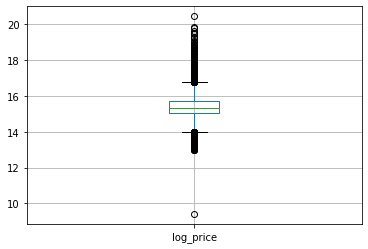

In [58]:
#Посмотрим на площадь и цену - построим боксплоты!
data['log_price'] = np.log(data['last_price']) #логарифмируем цены, чтобы стала понянее форма распределения
data.boxplot(column = 'log_price')


3.895665386401047


<AxesSubplot:>

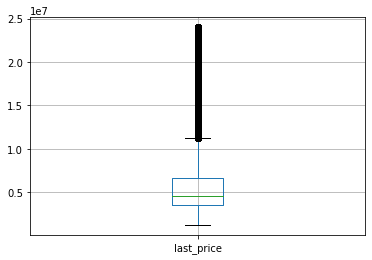

In [59]:
#Посмотрим, сколько данных отвалится, если удалить все строки вне "усов"
print(len(data.query('log_price < 14 | log_price > 17'))/len(data['total_area'])*100)
#Выбросы за усами составляют всего 4 процента данных, отбросим их.
data = data.query('~(log_price < 14 | log_price > 17)')
data.boxplot(column = 'last_price')

4.084321475625823


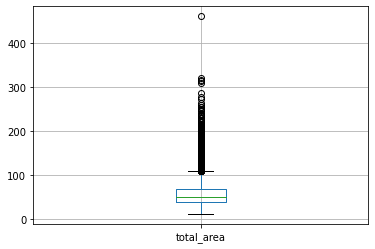

In [60]:
#Посмотрим на боксплот площади
data.boxplot(column = 'total_area')
print(len(data.query('total_area > 110')['total_area'])/len(data['total_area'])*100)

#huge_flats = data.query('total_area > 110')
#data = data.query('~(total_area > 110)')

Итак, квартиры с общей площадью больше 110 m2 составляют 4% всех квартир. 
Такой объем данных разрешимо отбросить - с учетом отброшенных ранее квартир с редкими ценами, мы отбросим 8% всех данных. Сохраним их на всякий случай в отдельный запасной датасет.

<AxesSubplot:>

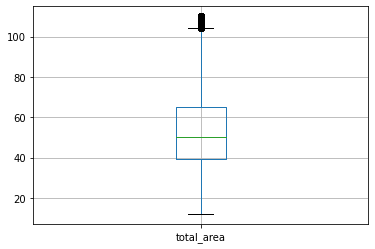

In [61]:
huge_flats = data.query('total_area > 110')
data = data.query('~(total_area > 110)')
data.boxplot(column = 'total_area')

<AxesSubplot:>

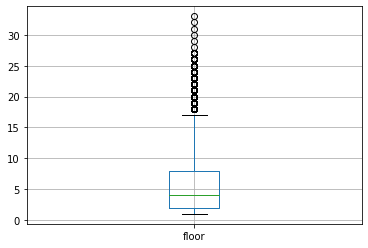

In [62]:
#посмотрим на этажи
data[data['floors_total'] < data['floor']] #проверим, нет ли тут "вылезающих" этажей
#таких аномалий не обнаружено

data.boxplot(column = 'floor')
#нет нулевых этажей, все значения выглядят правдоподобно, редких значений немного

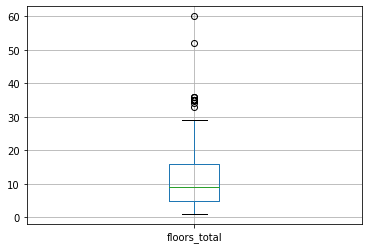

In [63]:
#проверим, что с количеством этажей
data.boxplot(column = 'floors_total') 
#теоретически, могут быть дома больше 50 этажей, но подозрительно. Посмотрим на них
data.query('floors_total > 50')
#первый случай похож на опечатку (т.е. на самом деле этажей в доме 6)
#объяснения для второго придумать не удалось - похоже, это действительно дом с 52 этажами.
data.loc[data['floors_total'] == 60, 'floors_total'] = 6

<AxesSubplot:>

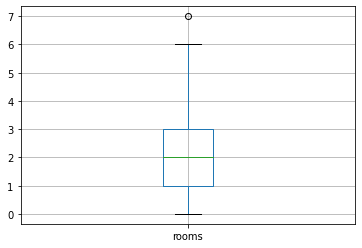

In [64]:
#посмотрим на количество комнат
data.boxplot(column = 'rooms') 
#тут все в порядке

**Обнаруженные особенности в данных:** 

1. В некоторых строках были допущены опечатки в столбце ceiling_height, что привело к появлению аномально высоких потолков. Так как природа аномалии была понятна, мы исправили эти значения. Также обнаружились квартиры с высотой потолка ниже 2 метров, которые представляют собой редкие значения - эти строки были удалены из датасета.

2. Очень дорогие и/или очень большие квартиры (ценой больше 18 миллионов и площадью больше 110 метров), хоть и не являются аномалиями (т.е. такие квартиры, скорее всего, реально существуют), все-таки являются редкими в датасете (суммарно они составляли около 8% всех данных) и искажают среднее и распределение важных нам показателей. Строки с такими значениями были удалены из датасета.

3. В датасете нашлись две квартиры в домах, где больше 50 этажей. В случае одной из квартир (на 4 этаже в доме с 60 этажами и вне большого города) мы посчитали это опечаткой и заменили значение на 6. В случае с другой квартирой (дом с 52 этажами в Санкт-Петербурге) опечатка кажется менее вероятной, строка была оставлена в датасете несмотря на аномальность значения.



## Посчитайте и добавьте в таблицу новые столбцы

In [65]:
#цена одного квадратного метра
data['price_per_m'] = data['last_price']/data['total_area']

In [66]:
#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek #day_name() - для проверки с названиями

In [67]:
#месяц публикации объявления
data['month'] = data['first_day_exposition'].dt.month

In [68]:
#год публикации объявления;
data['year'] = data['first_day_exposition'].dt.year

In [69]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
for i in data.index:
    if data.loc[i,'floor'] == data.loc[i,'floors_total']:
        data.loc[i,'type_floor'] = 'последний'
    elif data.loc[i,'floor'] == 1:
        data.loc[i,'type_floor'] = 'первый'
    else:
        data.loc[i,'type_floor'] = 'другой'

In [70]:
#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)
data['center_nearest_km'] = data['cityCenters_nearest']/1000
data['center_nearest_km'] = data['center_nearest_km'].round(2)

## Проведите исследовательский анализ данных

***
Изучим следующие параметры объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

Построим отдельные гистограммы для каждого из этих параметров. Опишим все ваши наблюдения по параметрам.

[Text(0, 0, '16220'), Text(0, 0, '2938'), Text(0, 0, '2682')]

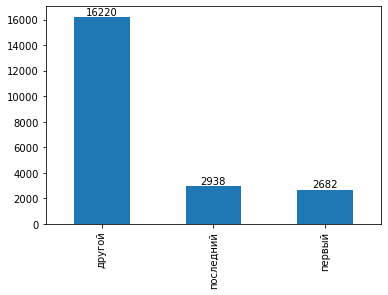

In [71]:
ax = data['type_floor'].value_counts().plot.bar()
ax.bar_label(ax.containers[0])

total_area
медиана: 50.2 ; среднее: 54.12810027472518 ; максимум: 110.0 ; минимум: 12.0 ; мода: 0    45.0
dtype: float64


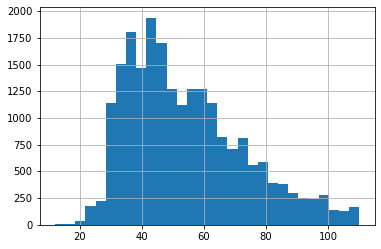

living_area
медиана: 30.0 ; среднее: 30.89643138804906 ; максимум: 101.0 ; минимум: 2.0 ; мода: 0    17.0
dtype: float64


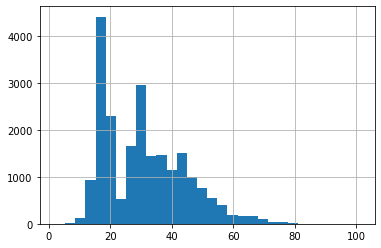

kitchen_area
медиана: 9.0 ; среднее: 9.807778846153813 ; максимум: 55.7 ; минимум: 1.3 ; мода: 0    8.0
dtype: float64


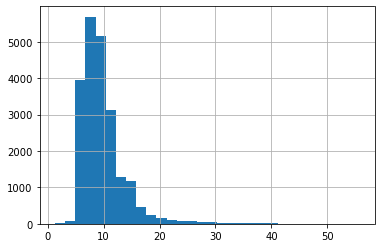

last_price
медиана: 4500000.0 ; среднее: 5249730.903159341 ; максимум: 24000000.0 ; минимум: 1220000.0 ; мода: 0    4500000.0
dtype: float64


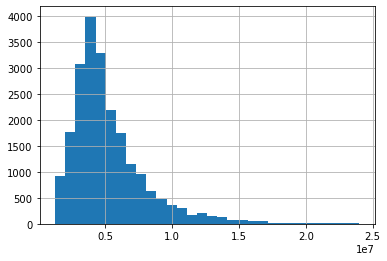

rooms
медиана: 2.0 ; среднее: 1.9433150183150183 ; максимум: 7 ; минимум: 0 ; мода: 0    1
dtype: int64


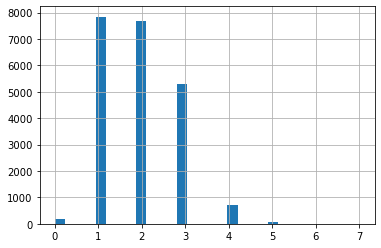

ceiling_height
медиана: 2.65 ; среднее: 2.6804574175827605 ; максимум: 8.3 ; минимум: 2.0 ; мода: 0    2.65
dtype: float64


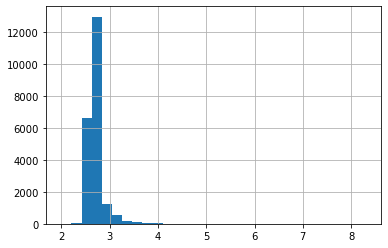

floor
медиана: 4.0 ; среднее: 5.979578754578754 ; максимум: 33 ; минимум: 1 ; мода: 0    2
dtype: int64


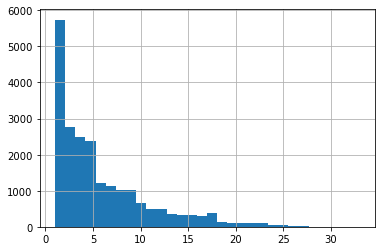

floors_total
медиана: 9.0 ; среднее: 10.9217407288268 ; максимум: 52.0 ; минимум: 1.0 ; мода: 0    5.0
dtype: float64


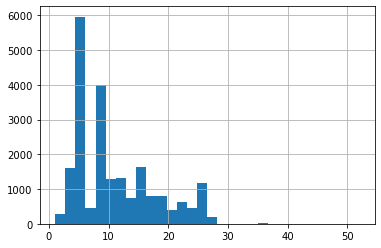

airports_nearest
медиана: 27767.0 ; среднее: 29650.126677010598 ; максимум: 84869.0 ; минимум: 0.0 ; мода: 0    51553.0
dtype: float64


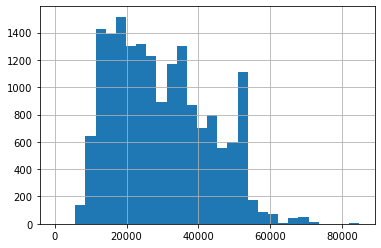

cityCenters_nearest
медиана: 13407.0 ; среднее: 14747.56008064524 ; максимум: 65968.0 ; минимум: 208.0 ; мода: 0    11601.291571
dtype: float64


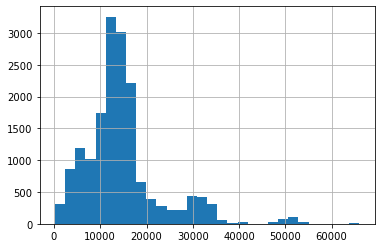

parks_nearest
медиана: 458.0 ; среднее: 494.28599412340844 ; максимум: 3190.0 ; минимум: 1.0 ; мода: 0    441.0
dtype: float64


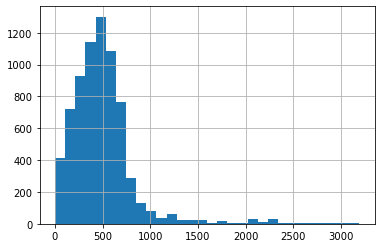

day_of_week
медиана: 3.0 ; среднее: 2.5690476190476192 ; максимум: 6 ; минимум: 0 ; мода: 0    3
dtype: int64


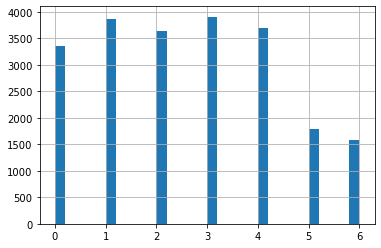

month
медиана: 6.0 ; среднее: 6.3968406593406595 ; максимум: 12 ; минимум: 1 ; мода: 0    2
dtype: int64


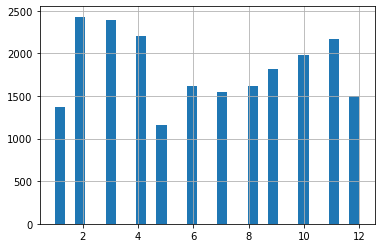

In [72]:
# 'type_floor' будет отдельно барплотом
analyze_cols = ['total_area', 'living_area','kitchen_area', 'last_price', 'rooms', 
                'ceiling_height','floor', 'floors_total', 'airports_nearest',
               'cityCenters_nearest', 'parks_nearest', 'day_of_week', 'month']
for col in analyze_cols:
    print(col)
    print('медиана:',data[col].median(),';','среднее:',data[col].mean(),';',
          'максимум:', data[col].max(),';','минимум:', data[col].min(), ';', 'мода:',data[col].mode())
    data[col].hist(bins = 30)
    plt.show()

### Наблюдения
***

**Общая площадь**: медиана: 50.2 ; среднее: 54.12810027472518 ; максимум: 110.0 ; минимум: 12.0. Распредление общей площади близко к нормальному, но имеет два пика - в области медианы и в области 45 м2.

**Жилая площадь**: медиана: 30.0 ; среднее: 30.89643138804906 ; максимум: 101.0 ; минимум: 2.0. Распределение по форме напоминает распределение общей площади, что довольно логично, однако в нем гораздо более выраженны два пика. Распредление как будто состоит из двух частей: первой с пиком в районе 17 м2 и второй в области медианы и среднего, около 30 м2. "Второе" распредление по форме скорее напоминает распределение Пуассона.

**Площадь кухни**: медиана: 9.0 ; среднее: 9.807778846153813 ; максимум: 55.7 ; минимум: 1.3. Распределение скорее ближе к распр. Пуассона, чем к нормальному, мы видим явный пик в области 8 м2, значительная часть значений сконцентрирована очень близко к среднему, к "хвостам" относится совсем мало значений, при этом "хвост" в сторону увеличения более длинный и пологий.

**Цена:** медиана: 4500000.0 ; среднее: 5249730.903159341 ; максимум: 24000000.0 ; минимум 1220000.0. По форме распределение цен похоже на распределение Пуассона, с пиком в медиане (равной моде) и длинным пологим "хвостом" справа.

**Комнаты:** медиана: 2.0 ; среднее: 1.9433150183150183 ; максимум: 7 ; минимум: 0. Больше всего в выборке квартир с 1-2 комнатами, дальше идут 3-комнатные квартиры. Квартиры с более 4 комнат и студии (0 комнат) составляют небольшую часть выборки.

**Высота потолков:** медиана: 2.65 ; среднее: 2.6804574175827605 ; максимум: 8.3 ; минимум: 2.0. Большая часть квартир имеют высоту потолков 2.65 метров (мода и медиана), что примерно соотвествует стандартной высоте потолков в большинстве современных домов. Такие квартиры составляют больше половины всех значений, еще четверть составляют квартиры с потолков 2.5 метров, все остальные варианты высоты потолков приходятся на оставшиеся 25% выборки.

**Этаж:** медиана: 4.0 ; среднее: 5.979578754578754 ; максимум: 33 ; минимум: 1. Здесь мы видим распределение Пуассона, чаще всего квартиры в выборке находятся на 2 этаже (возможно, это связано с тем, что меньше покупателей выбирают квартиры на 1 этаже и продавцы слегка искажают реальность при написании объявления). Большая часть квартир находятся на этажах в диапазоне с 2 по 5.

**Тип этажа:** Ожидаемо, больше 16 тысяч квартир из датасета не находятся ни на первом, ни на последнем этаже. Квартир на первом и последнем этаже примерно поровну (2.6 и 2.9 тысяч)

**Всего этажей:** медиана: 9.0 ; среднее: 10.9217407288268 ; максимум: 52.0 ; минимум: 1.0 ; мода: 5.0. Большинство квартир находятся в домах с 5 или 9 этажами, то есть в классических 5- и 9-этажках советской застройки. Также в выборке есть многооэтажные новостройки и малоэтажные дома.

**Расстояние до аэропорта:** медиана: 27767.0 ; среднее: 29650.126677010598 ; максимум: 84869.0 ; минимум: 0.0 ; мода: 51553.0. Квартиры в выборке находятся на расстоянии от 3км (если не считать одну уникальную квартиру со значением 0) до 85км, при этом в распредлении видно 3 отчетливых пика, которые могут быть связаны с опредленными населенными пунктами, в которых находится значительная часть квартир. Эту гипотезу мы проверим в дальнейшем анализе.

**Расстояние до центра города:** медиана: 13407.0 ; среднее: 14747.56008064524 ; максимум: 65968.0 ; минимум: 208.0 ; мода: 11601.291571. Здесь мы также не видим нормальное распредление, квартиры расположены на расстоянии от 208 метров до 65 км от центра города. Чаще всего квартиры находятся на расстоянии 11 км от центра.

**Растояние до парка:** медиана: 458.0 ; среднее: 494.28599412340844 ; максимум: 3190.0 ; минимум: 1.0 ; мода: 441.0. Среднее, медиана и мода здесь практически совпадают, основная часть квартир, рядом с которыми вообще есть парк, находится на расстоянии 400-1000 метров от ближайшего парка.

**День недели:** В основном объявления публикуют в будние дни, гораздо реже в выходные. При этом в будние дни каждый день публиковали примерно одинаковое число объявлений, но чаще всего во вторник и в четверг.

**Месяц публикации:** Больше всего объявлений опубликованы в феврале-апреле, меньше всего в месяцы праздников и национальных выходных - декабрь, январь и май. Летом объявлений публикуется меньше, и число объявлений постепенно растет с августа по ноябрь (и потом падает в декабре).

***
Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.* 
 
Построим гистограмму. Посчитаем среднее и медиану.
В ячейке типа markdown опишем, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?

days_exposition
медиана: 92.0 ; среднее: 174.3601109482939 ; максимум: 1580.0 ; минимум: 1.0 ; мода: 0    45.0
dtype: float64


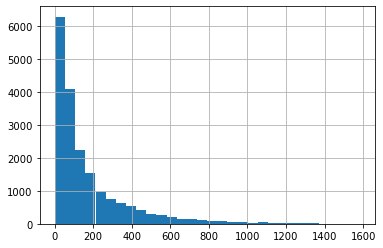

In [73]:
col = 'days_exposition'
print(col)
print('медиана:',data[col].median(),';','среднее:',data[col].mean(),';',
          'максимум:', data[col].max(),';','минимум:', data[col].min(), ';', 'мода:',data[col].mode())
data[col].hist(bins = 30)
plt.show()

**Выводы:** Распределение не является нормальным, поэтому среднее и медиана не так достоверно говорят нам о том, как "обычно" проходят продажи. Мода показывает, что чаще всего продажа занимает 1.5 месяца (45 дней). Судя по форме распредления, можно сказать, что квартира "висит" необычно долго, если продажа не происходит в течении 200 дней. 45-92 дня (1.5-3 месяца) - нормальный срок продажи квартиры. Минимальный срок продажи - 1 день, кажется слишком быстрым, вполне возможно, что это была не продажа, и хозяин просто по какой-то причине решил снять объявление раньше (передумал продавать, хотел внести изменения и не разобрался с системой и т.п.).
    

***
Какие факторы больше всего влияют на общую (полную) стоимость объекта?
Изучим, зависит ли цена от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).

Построим графики, которые покажут зависимость цены от указанных выше параметров.


In [74]:
price_effect_categ = ['rooms','type_floor', 'day_of_week', 'month', 'year'] #категории
price_effect_num = ['total_area', 'living_area', 'kitchen_area'] #количественные переменные

total_area


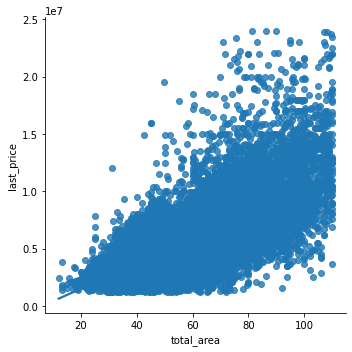

Корреляция Пирсона и p-value: (0.7170443520258527, 0.0)
-------------------------------------------

living_area


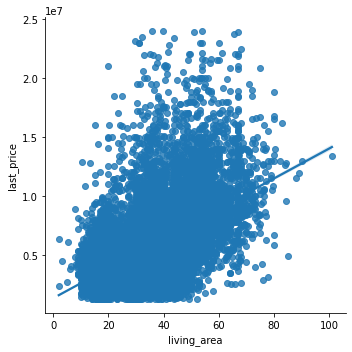

Корреляция Пирсона и p-value: (0.5824717780958408, 0.0)
-------------------------------------------

kitchen_area


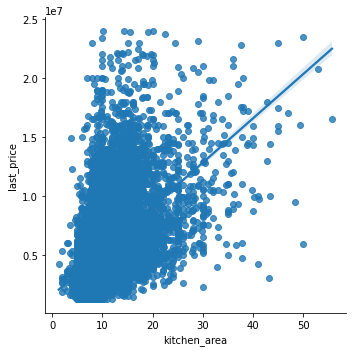

Корреляция Пирсона и p-value: (0.527712214030765, 0.0)
-------------------------------------------



In [75]:
for num in price_effect_num:
    print(num)
    sb.lmplot(data = data, x = num, y = 'last_price')
    plt.show()
    print('Корреляция Пирсона и p-value:',stats.pearsonr(data['last_price'], data[num]))
    print('-------------------------------------------')
    print('')

**Выводы по связи цены с количественными переменными (площадью):**

Мы видим высокую корреляцию между площадью квартиры и ее ценой - 0.71, что вполне ожидаемо, за большую площадь обычно ставят цену выше. С жилой площадью и площадью кухни корреляция меньше, хотя все еще довольно внушительная - 0.58 и 0.52 соотвественно. 

(p-value во всех случаях стремится к нулю, что скорее всего связано просто с тем, что у нас очень много наблюдений)
***

         last_price
rooms              
0      3.012814e+06
1      3.870252e+06
2      5.448398e+06
3      6.761797e+06
4      7.286987e+06
5      7.713750e+06
6      1.154438e+07
7      1.349000e+07


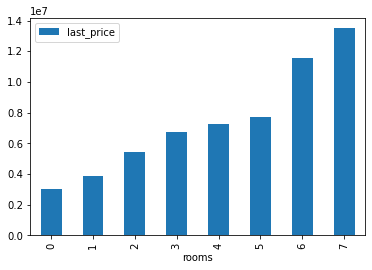

-------------------------------------------

              last_price
type_floor              
другой      5.451604e+06
первый      4.392263e+06
последний   4.917991e+06


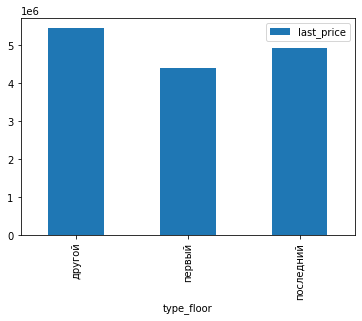

-------------------------------------------

               last_price
day_of_week              
0            5.287949e+06
1            5.295125e+06
2            5.255254e+06
3            5.274031e+06
4            5.206289e+06
5            5.163907e+06
6            5.183508e+06


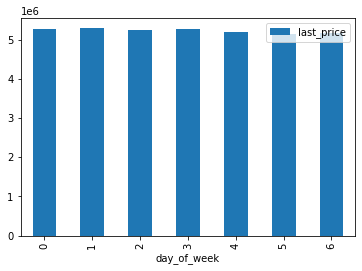

-------------------------------------------

         last_price
month              
1      5.302781e+06
2      5.249070e+06
3      5.222509e+06
4      5.385362e+06
5      5.159326e+06
6      5.118072e+06
7      5.228406e+06
8      5.236049e+06
9      5.381371e+06
10     5.199619e+06
11     5.254980e+06
12     5.193492e+06


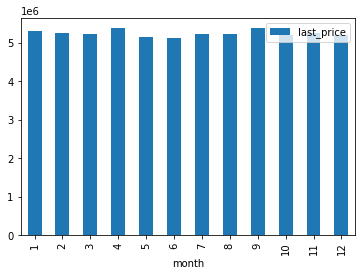

-------------------------------------------

        last_price
year              
2014  7.039063e+06
2015  5.705302e+06
2016  5.174226e+06
2017  5.138511e+06
2018  5.174248e+06
2019  5.618693e+06


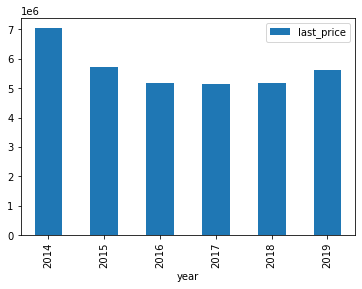

-------------------------------------------



In [76]:
for categ in price_effect_categ:
    piv = data.pivot_table(index = categ, values = 'last_price')
    print(piv)
    piv.plot(kind = 'bar')
    plt.show()
    print('-------------------------------------------')
    print('')

**Выводы по связи категориальных переменных и цены:**

- Чем больше комнат, тем больше средняя цена квартиры.
- Квартиры на первом этаже в среднем дешевле, чем квартиры на последнем этаже и на других этажах, при этом квартиры на последнем этаже дешевле квартир на других этажах.
- Цена не зависела от дня и месяца публикации.
- В 2014 году средние цены были выше, чем в последующие годы. В 2016-2018 годах средняя цена оставалась примерно на одном уровне, в 2019 мы видим небольшое повышение средней цены на квартиру.

***
Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [77]:
pop_locality = data.groupby('correct_locality')['last_price'].count().sort_values(ascending = False)[0:10]
print(pop_locality.index)

Index(['санкт-петербург', 'поселок мурино', 'поселок шушары', 'всеволожск',
       'пушкин', 'колпино', 'поселок парголово', 'гатчина', 'деревня кудрово',
       'выборг'],
      dtype='object', name='correct_locality')


In [78]:
#сделаем датасет для самых популярных населенных пунктов
pop_locality = data.query('correct_locality in @pop_locality.index') 

In [79]:
pop_locality.pivot_table(index = 'correct_locality', values = 'price_per_m').sort_values(by ='price_per_m')

,price_per_m
correct_locality,
выборг,58984.701422
всеволожск,67309.220512
гатчина,69416.321082
колпино,75370.025473
поселок шушары,78713.666565
поселок мурино,85681.762601
поселок парголово,90332.263023
деревня кудрово,92409.726322
пушкин,101879.079761


**Выводы по самым популярным населенным пунктам и ценам за м2:**

- В число 10 самых популярных населенных пунктов попали: Санкт-Петербург, поселок Мурино, поселок Шушары, Всеволожск, Пушкин, Колпино, поселок Парголово, Гатчина, деревня Кудрово и Выборг.
- Самые высокие цены за м2 в Санкт-Петербурге (109362 рублей), а самые низкие в Выборге (58984 рублей).

***


Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишем, как стоимость объектов зависит от расстояния до центра города.

<AxesSubplot:xlabel='center_nearest_km', ylabel='last_price'>

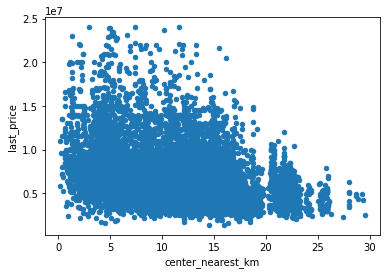

In [145]:
peter = data.query('correct_locality == "санкт-петербург"')
peter.plot(kind = 'scatter', x = 'center_nearest_km', y = 'last_price')


In [141]:
#Виден один выброс в районе 28 километра, который точно потом собьет статистику. 
#Найдем его и выкинем
print(peter.query('last_price > 10000000 & center_nearest_km > 25')) #индекс 748
peter = peter.drop(748)
peter.query('last_price > 10000000 & center_nearest_km > 25')

#отлично, аномалия удалена

     total_images  last_price  total_area first_day_exposition  rooms  \
748            13  14350000.0        74.0           2017-11-28      2   

     ceiling_height  floors_total  living_area  floor is_apartment  ...  \
748            3.13           5.0         30.0      3          NaN  ...   

     total_area_category  living_kitchen  year  correct_locality  log_price  \
748                    5            55.0  2017   санкт-петербург  16.479261   

       price_per_m  day_of_week  month  type_floor  center_nearest_km  
748  193918.918919            1     11      другой              27.31  

[1 rows x 32 columns]


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,total_area_category,living_kitchen,year,correct_locality,log_price,price_per_m,day_of_week,month,type_floor,center_nearest_km


In [142]:
#Чтобы отпределить цены за каждый километр, попробуем найти среднюю ценю для 
#квартир на каждом километре от центра
peter['km_rounded'] = peter['center_nearest_km'].round(0)
peter_km = peter.pivot_table(index = 'km_rounded', values = 'last_price')

<AxesSubplot:xlabel='km_rounded', ylabel='last_price'>

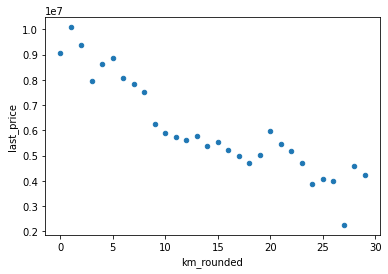

In [158]:
peter_km.plot(kind = 'scatter', x = 'km_rounded' ,y = 'last_price')

На графике мы видим, что средняя цена дейсвительно в целом снижается с отдалением от центра, хотя в радиусе 5 километров от центра картина не такая однозначная - тут это происходит нелинейно. Также мы видим интересное повышение цены с 18 по 20 километр, после которого она снова линейно снижается.

***
Теперь подсчитаем разницу между средней ценой квартир для каждого километра.
У нас получится колонка, где напротив каждого километра стоит число, показывающее разницу в средней цене квартир на этом километре и на километр дальше от центра

Условно, сколько в среднем придется "доплатить", чтобы быть на **этот** километр ближе к центру.

In [146]:
for index in peter_km.index:
    try:
        peter_km.loc[index,'delta_price'] = peter_km.loc[index,'last_price'] - peter_km.loc[index+1,'last_price']
    except:
        print('это был последний километр')

это был последний километр


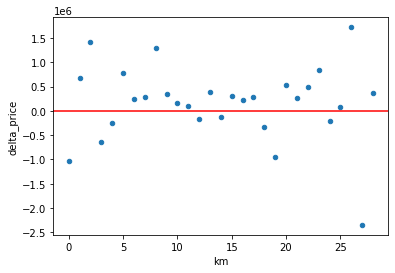

In [161]:
peter_km['km'] = peter_km.index
peter_km.plot(kind = 'scatter', x = 'km', y = 'delta_price').axhline(y=0, color='r', linestyle='-')

**Выводы по зависимоти цены квартиры в Санкт-Петербурге от расстояния до центра:**

- Cредняя цена на квартиру в целом снижается с отдалением от центра, хотя в радиусе 5 километров от центра картина не такая однозначная - тут это происходит нелинейно. Также мы видим интересное повышение цены с 18 по 20 километр, после которого она снова линейно снижается. Возможно, на этом расстоянии расположено что-то, что немного повышает привлекательность жилья, например, удобная кольцевая дорога или популярный парк.
- График дельт для каждого последующего километра показывает, что дейсвительно в самых центральных километрах (5 км от центра) более "центральные" квратиры могут стоит дешевле. Возможно это связано с формой центра Санкт-Петербурга, который представлет собой не круг, а группу островов с разной привлекательностью жилья. 
- В целом можно сказать, что снижение цены на квартиры с отдалением от центра происходит равномерно (прктически все дельты попадают в интервал от 0 до 1.5 миллионов)

## Общий вывод

Нами были изучены данные по продаже квартир с 2014 по 2019 год в Санкт-Петербурге и соседних населенных пунктах. Можно представить следующие выводы:

- Мы обнаружили тесную связь цен на квартиры с общей площадью квартиры (корреляция = 0.7), а также с площадью жилого простраства и кухни (корреляции 0.6 и 0.5 соотественно)
- Цена на квартиры на первом и последнем этажах в среднем ниже, чем на квартиры на других этажах
- Выше всего средняя цена за метр квадратный в Санкт-Петербурге (около 109 тысяч рублей), ниже всего - в Выборге (около 58 тысяч)
- Большая часть квартир продается в Санкт-Петербурге
- Большая часть квартир продается в советском жилом фонде 5 и 9-этажек
- В основном объявления публикуют в будние дни, гораздо реже в выходные. При этом в будние дни каждый день публиковали примерно одинаковое число объявлений, но чаще всего во вторник и в четверг.Больше всего объявлений опубликованы в феврале-апреле, меньше всего в месяцы праздников и национальных выходных - декабрь, январь и май. Летом объявлений публикуется меньше, и число объявлений постепенно растет с августа по ноябрь (и потом падает в декабре). При этом цена не зависела ни от дня, ни от месяца публикации.
- В 2014 году средние цены были выше, чем в последующие годы. В 2016-2018 годах средняя цена оставалась примерно на одном уровне, в 2019 мы видим небольшое повышение средней цены на квартиру.
- Чаще всего продажа квартиры занимала 1.5 месяца (45 дней). Можно сказать, что квартира "висит" необычно долго, если продажа не происходит в течении 200 дней. 45-92 дня (1.5-3 месяца) - нормальный срок продажи квартиры. 